Proyecto, parte 1: Preprocesamiento y guardado


In [112]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


El proyecto se separará en dos redes, la encargada de clasificar los esquematicos y la encargada de clasificar los componentes. 

De momento se realizaron los siguientes cambios:
- Inspección de todas las imagenes para retirar cualquier archivo que no fuera de algún tipo de imagen
- renombrado de las carpetas correspondientes para tener (tipo se refiere a esquematico o componente, y dispositivo al nombre en sí):
  - Data/"Tipo"/"Dispositivo"  
- Preprocesado cargando las carpetas previas, escalado 64x64 y 32x32 para pruebas
  - Aquellas imagenes que no fueran cuadradas se les agregó un fondo blanco cuadrado igual a su dimensión mayor
  - Todas se convirtieron a RGB para que tuvieran 3 capas (algunos esquematicos usan colores)

- Listado de razones:
  - Se escalo a 64 y 32 como números usuales y para comparar resultados
  - Se agregó un fondo para evitar deformaciones en dispositivos que son alargados (resistencias) y de los esquematicos.
    - El fondo es blanco ya que ya existe una parte del conjunto que es así
  - Se convierte a RGB para homogeniezar las capas de la entrada
  - Posiblemente se mezclen las categorias de: Motor con Ventilador, Capacitores ceramicos con Capacitores electrolitico, Diodo led con Diodo en la tarea de esquematicos al ser muy similares.

El preprocesador carga los datos originales desde Github, se forma un zip y se descarga. \
Esta parte ya está comentada y directamente cargo el zip previamente generado desde Github también.\
Los datos están guardados en formato np.array y son cargados con pickle



Proyecto Parte 2: Implementado completo

- Cambios respecto la parte anterior: Se modificó la base de datos para el preprocesamiento:
  - Similitud en esquematicos de 3 pares de clases (motor/ventilador, led/diodo, y capacitor ceramico y capacitor electrolitico)
- Forma de aplicación: Se realizaron 2 redes, una para cada uno de los problemas, la arquitectura es similar cambiando el tamaño de los filtros (este cambio se ilustra usando parentesis y corchetes)


- Arquitectura de las redes: \
En general se emplean funciones de activación ReLU y BatchNormalization(considerando normalizado y escalado) \
(Componentes), [Esquematicos]

  - Red de (Componentes)/[Esquematicos]: 
    - 3 convolucionales en paralelo de 8 filtros cada una
      - (9x9, 2x7 y 7x2) , [3x3, 1x5, 5x1]
    - 1 convolucional de 16 filtros 
      - (5x5)
    - DropOut
    - Densa de 512
    - DropOut
    - Densa de número de componentes
    - Softmax
- Función de error: Entropia Cruzada Multietiqueta + Norma L2, $\lambda = 10^{-6}$

- Optimizador: Adam, Lr = 0.05, $\epsilon= 10^{-10}$   

- Resultados: Ambas redes logran un 90% (en training) y un (50% en test) de accuracy

- Consideraciones: \
El dataset preprocesado, así como las versiones de los modelos entrenados son cargadas desde GitHub, 
nuevamente se comentan los pasos de:
- Preprocesamiento
- Entrenamiento

Se considera que el sistema tiene un overfitting, la cantidad de entradas es mucho menor que el número de parametros. \
El sistema tuvo mejores iteraciones pero se debieron a la inicialización de los pesos. \
En el caso de esquematicos, la cantidad de capacitores presenta un desbalance en el clasificador.
Siguen existiendo problemas de similitud entre componentes de geometría similar (cilindros, circulos y rectangulos se confunden entre sí)\
Se recomienda emplear en lugar de sólo 2 redes un ensable de clasificadores:
- Primer clasificador distingue entre esquematico/componente
- Segundo clasificador separa la geometría  (cilindrico, rectangular, circular)
- Tercerá capa de redes clasifica el esquematico/componente dependiendo de la geometría (son 6 clasificadores en la tercer capa)



# Parte I: Preprocesado y carga

In [113]:
# Bloque de imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from PIL import Image,ImageOps, ImageDraw #Libreria de imagenes
import os
from shutil import rmtree #Para limpieza de datos
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import tensorflow as tf

#Para descargar los archivos:
from google.colab import files


#Para tensorboard:
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [114]:
#Obtención de información desde Git
! git clone https://github.com/enoc494/ProyectoCircuitos-ANN.git

Cloning into 'ProyectoCircuitos-ANN'...
remote: Enumerating objects: 2332, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 2332 (delta 31), reused 54 (delta 13), pack-reused 2257
Receiving objects: 100% (2332/2332), 228.32 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (543/543), done.
Checking out files: 100% (1507/1507), done.


In [115]:
%ls

Bocina51.png  Bocina57.png  Bocina63.jpg  Bocina69.jpg  Bocina75.png
Bocina52.png  Bocina58.png  Bocina64.png  Bocina70.png  ProyectoCircuitos-ANN/
Bocina53.png  Bocina59.png  Bocina65.png  Bocina71.png
Bocina54.jpg  Bocina60.jpg  Bocina66.png  Bocina72.png
Bocina55.png  Bocina61.png  Bocina67.jpg  Bocina73.jpg
Bocina56.png  Bocina62.png  Bocina68.png  Bocina74.jpg


In [116]:
%cd ProyectoCircuitos-ANN/

/content/ProyectoCircuitos-ANN/Data/Esquematicos/Bocinas/ProyectoCircuitos-ANN


In [117]:
%ls

Borrador_Proyecto_Circuitos_RNAA.ipynb  Data/        Data.rar
CNN_Componentes_Modelo_3                Data0/       Log.txt
CNN_Esquematicos_Modelo_5               DataPrep64/  README.md


In [118]:
!cd /content/ProyectoCircuitos-ANN

In [119]:
os.getcwd()

'/content/ProyectoCircuitos-ANN/Data/Esquematicos/Bocinas/ProyectoCircuitos-ANN'

In [120]:
#paths declarados de utilidad 
dir = "/content/ProyectoCircuitos-ANN/"
dirData = dir+'/Data'



In [121]:
dir

'/content/ProyectoCircuitos-ANN/'

In [122]:
os.listdir()

['Data',
 'DataPrep64',
 'Borrador_Proyecto_Circuitos_RNAA.ipynb',
 'README.md',
 'CNN_Esquematicos_Modelo_5',
 'Log.txt',
 'Data0',
 '.git',
 'CNN_Componentes_Modelo_3',
 'Data.rar']

In [123]:
#listado de Tipos de entradas
os.chdir(dirData)
listaDeEntradas = os.listdir()

In [124]:
listaDeEntradas

['Componentes', 'Esquematicos']

In [125]:
# Ejemplo de un preprocesado:
os.chdir(dirData+'/Esquematicos/')
listaDeDispositivosEsquematicos = os.listdir()

os.chdir(dirData+'/Componentes/')
listaDeDispositivosComponentes = os.listdir()

os.chdir(dirData+'/Esquematicos/'+listaDeDispositivosEsquematicos[1])
imagenes = os.listdir()

In [126]:
listaDeDispositivosEsquematicos

['Conectores',
 'Bocinas',
 'Potenciometros',
 'Resistencias',
 'Motores',
 'Diodos',
 'Transistores',
 'PushButtons',
 'LCD',
 'Baterias',
 'Circuitos Integrados',
 'Fusibles',
 'DipSwitches',
 'Capacitores',
 'Bobinas']

In [127]:
listaDeDispositivosComponentes


['Ventiladores',
 'Conectores',
 'Bocinas',
 'Potenciometros',
 'Resistencias',
 'Motores',
 'Diodos',
 'Transistores',
 'PushButtons',
 'Capacitores-Electroliticos',
 'LED',
 'LCD',
 'Baterias',
 'Capacitores-Ceramicos',
 'Circuitos Integrados',
 'Fusibles',
 'DipSwitches',
 'Bobinas']

In [128]:
imagen = Image.open(imagenes[0])
imagen.convert('RGB')
imagen

In [129]:
a,b=imagen.size

if a!=b: #Si no coincide el ancho/largo
  if a>b:
    im = Image.new('RGB', (a, a), (255, 255, 255))
    im.paste(imagen, (0,0))
    imagen = im 
  else:
    im = Image.new('RGB', (b, b), (255, 255, 255))
    im.paste(imagen, (0,0))
    imagen = im 

In [130]:
imagen.size

(32, 32)

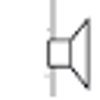

In [131]:
imagen.resize((100,100))

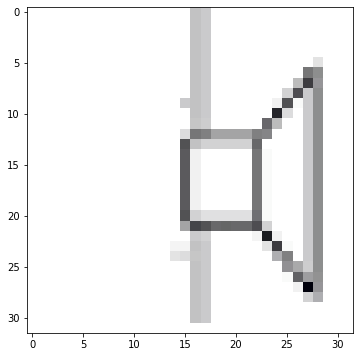

In [132]:
imagen.resize((64,64))  #Escalar, 64 x 64 en ejemplo

#Antes del resize realizar un fill de blanco :D

 #Ilustración de las 3 capas a usar
imagen2 = np.array(imagen)

fig1 = plt.figure(figsize=(6,6))
plt.imshow(imagen2)

In [133]:
#Limpieza del directorio por si hubo algo antes de preprocesar:
try:
  rmtree( dir +'DataPrep')
except FileNotFoundError:
  print('nada que borrar')

# Bloque usado solo en el preprocesamiento  

nada que borrar


#### Función de Carga, Preprocesado y Guardado de Datos


In [134]:
#función para preprocesar datos:
def PreprocesarDatos(size,tipo,dispositivos):
  """
  el tamaño deseado,
  tipo ingresado
  la lista de dispositivos a revisar (la lista de las clases es diferente!!!)
  """

  #Este proceso se debe repetir para cada tipo

  os.chdir(dir) # Carpeta superior 
  #Preparamos sitios de almacenamiento

  try:
    os.chdir( dir+'DataPrep/')  
  except FileNotFoundError:
    os.mkdir( dir+'DataPrep/')
    os.chdir( dir+'DataPrep/')
  
  try:
    os.chdir( dir+'DataPrep/'+tipo)  
  except FileNotFoundError:
    os.mkdir( dir+'DataPrep/'+tipo)
    os.chdir( dir+'DataPrep/'+tipo)
  
  for dispositivo in dispositivos:
    #Por cada tipo realizaremos el número de carpeta correspondiente
    try:
      os.chdir( dir+'DataPrep/'+tipo+'/'+dispositivo)  
    except FileNotFoundError:
      os.mkdir( dir+'DataPrep/'+tipo+'/'+dispositivo)
      os.chdir( dir+'DataPrep/'+tipo+'/'+dispositivo)
    #Con la carpeta destino creada nos movemos a la ubicación de las imagenes

    os.chdir(dir+'Data/'+tipo+'/'+dispositivo) #Se supone existe
    print('Actualmente en: ',tipo+', '+dispositivo)
    
    imagenes = os.listdir()
  
    #Acumuladores de datos procesados
    x_v=[]
    y_v=[]
    for imagenName in imagenes:
  
      imagen = Image.open(imagenName)
      imagen2 = imagen.convert('RGB') #Todo a RGB
      
      a,b=imagen2.size
      if a!=b: #Si no coincide el ancho/largo
        if a>b:
          #nuevo fondo
          im = Image.new('RGB', (a, a), (255, 255, 255)) 
          im.paste(imagen2, (0,0))
        else:
          #nuevo fondo
          im = Image.new('RGB', (b, b), (255, 255, 255))
          im.paste(imagen2, (0,0))
      else:
        im = imagen2 #Por si sí es cuadrada

      im = im.resize((size,size))  #Escalar
      
      imagen3 = np.array(im)
      imagen3 = imagen3/255 #Normalizado
      x_v.append(imagen3) 

    y_v.append(dispositivo)
    y_v=y_v*len(x_v) #Número de veces que se debe repetir el target
    x_v=np.array(x_v)
    y_v=np.array(y_v)
  
    #Esto se puede hacer con un with
    os.chdir(dir +'DataPrep/'+tipo+'/'+dispositivo) 
    pickle.dump(x_v, open(dispositivo+"Data", 'wb'))
    pickle.dump(y_v, open(dispositivo+"Target", 'wb'))
    #Regresamos al directorio donde se encuentran el resto, mejorar con with




In [135]:
#Implementación de la función anterior
#PreprocesarDatos(64,"Esquematicos",listaDeDispositivosEsquematicos) #Preprocesa Esquematicos
#PreprocesarDatos(64,"Componentes",listaDeDispositivosComponentes)  #Preprocesa Componentes


In [136]:
#!zip -r file.zip /content/ProyectoCircuitos-ANN/DataPrep 

In [137]:
#Descarga del FOLDER con modificaciones
#files.download("file.zip") 

In [138]:
#Revisión rápida de los datos

In [139]:
#os.chdir(dir)
#r=pickle.load(open('/content/ProyectoCircuitos-ANN/DataPrep/Esquematicos/Baterias/BateriasData','rb'))

In [140]:
#plt.figure()
#plt.imshow(r[0])

#### Función de Carga de datos Preprocesados

In [141]:
# dir+'DataPrep/'+tipo+'/'+dispositivo
def CargadorDatos(tipo,dispositivos,direccion):
  #Se elije el tipo y dispositivo a cargar en cada iteración
  x_test =[]
  x_train=[]
  y_test =[]
  y_train=[]
  
  #Moviendonos a la ubicación
  for dispositivo in dispositivos:

    os.chdir(direccion+'/'+tipo+'/'+dispositivo)
    data = pickle.load(open(dispositivo+'Data','rb')) 
    #Split de entrenamiento aquí para evitar malas tendencias

    x_train_v , x_test_v = train_test_split(data, test_size=0.20,shuffle=True)

    x_train.extend( x_train_v )
    
    x_test.extend( x_test_v )

    y_train.extend([str(dispositivo)]*len(x_train_v)*1 )
    y_test.extend( [str(dispositivo)]*len(x_test_v)*1)
  return np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)

## Preparado para tensorboard

In [142]:
#Subimos a directorio principal para guardado aquí de los logs
os.chdir(dir)

In [143]:
os.getcwd()

'/content/ProyectoCircuitos-ANN'

In [144]:
rm -rf ./logs/

In [145]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#Directorios de guardado de la info:
train_log_dir = 'logs/gradient_tape/'  + current_time + '/train'
test_log_dir  = 'logs/gradient_tape/'  + current_time + '/test'

#Escritores de la info:
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer  = tf.summary.create_file_writer(test_log_dir)


### Primer carga de datos
Primero el problema de componentes:

In [146]:
#implementación de la función anterior
# A elegir el tipo de carga

#direccion = dir+'DataPrep32'
direccion = dir+'DataPrep64'

x_train,x_test,y_train,y_test = CargadorDatos('Componentes',listaDeDispositivosComponentes,direccion)
#x_train,x_test,y_train,y_test = CargadorDatos('Esquematicos',listaDeDispositivosEsquematicos,direccion)

In [147]:
#Forma de los datos
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((821, 64, 64, 3), (210, 64, 64, 3), (821,), (210,))

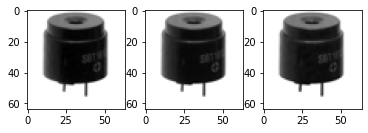

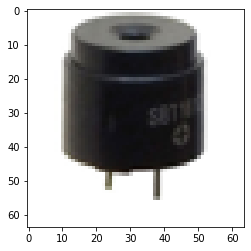

In [148]:
#Input
ex=x_train[100]

fig2 = plt.figure(figsize=(6,10))
ax   = fig2.add_subplot(1,3,1)
ax.imshow(ex[:,:,0],cmap='gray')
ax   = fig2.add_subplot(1,3,2)
ax.imshow(ex[:,:,1],cmap='gray')
ax   = fig2.add_subplot(1,3,3)
ax.imshow(ex[:,:,2],cmap='gray')

fig3 = plt.figure()
plt.imshow(ex)

In [149]:
#Aplicando one-hot y creando diccionario de traducción del mismo:

onehot_encoderC = OneHotEncoder(sparse=False)

y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoderC.fit_transform(y_train)


y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoderC.fit_transform(y_test)

#### Shuffle para evitar aprender el orden de los datos

In [150]:
x_trainC, y_trainC, y_train_onehotC = shuffle(x_train, y_train, y_train_onehot, random_state=None)
x_testC,  y_testC,  y_test_onehotC  = shuffle(x_test,  y_test,  y_test_onehot,  random_state=None)

### Etapa 2: Diseño de las redes

- Optimizador, y métricas a usar
- Grafo computacional (train y test)
- Entrenamiento
- Implementado y pseudoevaluado
- Muestra de ejemplos clasificados 

In [151]:
class CNN_Model(object):
  def __init__(self, clases ): 
      # Capas convolucionales

    amp=0.001 #amplitud del rand

    #3 convolucionales paralelas entre sí

    self.h1LW_A = tf.Variable(amp*np.random.randn(9,9,3,8),name="hl1_Aweigths",dtype="float32")
    self.h1LB_A = tf.Variable(amp*np.random.randn(8),name="hl1_Abias",dtype="float32")

    self.h1LW_B = tf.Variable(amp*np.random.randn(2,7,3,8),name="hl1_Bweigths",dtype="float32")
    self.h1LB_B = tf.Variable(amp*np.random.randn(8),name="hl1_Bbias",dtype="float32")

    self.h1LW_C = tf.Variable(amp*np.random.randn(7,2,3,8),name="hl1_Cweigths",dtype="float32")
    self.h1LB_C = tf.Variable(amp*np.random.randn(8),name="hl1_Cbias",dtype="float32")

  
        #MAX pooling (no tiene pesos)

        #Convolución con 16 filtros
    self.h2LW = tf.Variable(amp*np.random.randn(5,5,8*3,16),name="hl2weigths",dtype="float32")
    self.h2LB = tf.Variable(amp*np.random.randn(16),name="hl2bias",dtype="float32")
    

        #MAX pooling (no tiene pesos)

        #Flatten final
    self.h3LW = tf.Variable(amp*np.random.randn(16*16*16,512),name="hl3weigths",dtype="float32")
    self.h3LB = tf.Variable(amp*np.random.randn(512),name="hl3bias",dtype="float32")
  
    

      #Capas completamente conectadas
        #Primera reducción
    self.outW = tf.Variable(amp*np.random.rand(512, clases),name="outweigths",dtype="float32")
    self.outB = tf.Variable(amp*np.random.rand(clases),name="outbias",dtype="float32")
    
    #Para el grafo computacional, variables a entrenar:
    self.trainable_variables =[self.h1LW_A,self.h1LB_A,
                               self.h1LW_B,self.h1LB_B,
                               self.h1LW_C,self.h1LB_C,
                               self.h2LW,self.h2LB,
                               self.h3LW,self.h3LB,
                               self.outW,self.outB]

  
  def __call__(self,x,rate1=0,rate2=0):
      x   = tf.cast(x, tf.float32) #Volvemos float32 porque TF explota sino (? aver)
      img = tf.reshape(x, shape=[-1, 64, 64, 3])  #Reshape con: batch, ancho, alto, colores 
      # 64*64*3
     
      # Primer Convolucional 
      l1_A = tf.nn.conv2d(img, self.h1LW_A, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color  
    
      l1_A = tf.add(l1_A, self.h1LB_A)
      l1_A = tf.nn.relu(l1_A)
      l1_A = tf.nn.max_pool(l1_A, ksize=2, strides=2, padding='SAME' )
      l1_A = self.Normalizar(l1_A)
      # 32 * 32 * 16
      
       #Segunda convolucional paralela
      l1_B = tf.nn.conv2d(img, self.h1LW_B, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color        
      l1_B = tf.add(l1_B, self.h1LB_B)
      l1_B = tf.nn.relu(l1_B)
      l1_B = tf.nn.max_pool(l1_B, ksize=2, strides=2, padding='SAME' )
      l1_B = self.Normalizar(l1_B)
      # 32 * 32 * 16

        #Tercera convolucional paralela
      l1_C = tf.nn.conv2d(img, self.h1LW_C, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color        
      l1_C = tf.add(l1_C, self.h1LB_C)
      l1_C = tf.nn.relu(l1_C)
      l1_C = tf.nn.max_pool(l1_C, ksize=2, strides=2, padding='SAME' )
      l1_C = self.Normalizar(l1_C)
      
      # 32 * 32 * 16


      l1 = tf.concat([l1_A,l1_B,l1_C],3)
      l1 = tf.nn.dropout(l1,rate1)  


      #Concatenado de las tres paralelas 32*32*(16+16+16)
      
      
      l2 = tf.nn.conv2d(l1,self.h2LW, strides=[1,1,1,1], padding='SAME')  
      l2 = tf.add(l2, self.h2LB)
      l2 = tf.nn.relu(l2)
      l2 = tf.nn.max_pool(l2, ksize=2, strides=2, padding='SAME')
      l2 = self.Normalizar(l2)
      l2 = tf.nn.dropout(l2,rate1)  
      # 16 * 16 * 32
      
      #Capas completamente conectadas
      l3 = tf.reshape(l2,[-1, 16*16*16])
      l3 = tf.add(tf.matmul(l3,self.h3LW),self.h3LB)
      l3 = tf.nn.relu(l3)
      
      l3 = self.Normalizar(l3)

      l3 = tf.nn.dropout(l3,rate2)    
   
      
      output = tf.add( tf.matmul(l3,self.outW) , self.outB)
      #output = output/tf.reduce_max(output)


      return output 

  
  def Normalizar(self, layerIn):
      f = tf.reduce_max(abs(layerIn))
      m = tf.reduce_mean(layerIn)
      s = tf.math.reduce_std(layerIn)
      return (layerIn-m)/(s*f)         

#### Declarado de la arquitectura 1: Componentes

In [152]:
#Prueba de propagación hacía adelante e instancia de ambas redes
CNN_Componentes = CNN_Model(clases = len(listaDeDispositivosComponentes))

CNN_Componentes(x_train[10])
 

<tf.Tensor: shape=(1, 18), dtype=float32, numpy=
array([[ 0.02526895, -0.02950868,  0.03045067, -0.0704179 , -0.0750424 ,
        -0.06230906, -0.02533766,  0.2592907 , -0.22642955,  0.06050433,
         0.10462012, -0.32609797,  0.14221935, -0.10989872, -0.19093658,
         0.21002948,  0.16854823, -0.08543865]], dtype=float32)>

In [153]:

#Metricas a usar
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [154]:
  ############## Declarado del optimizador
  optimizador = tf.compat.v1.train.AdamOptimizer( learning_rate=0.05,epsilon= 1e-10)
  ##############    
  

In [155]:
#@tf.function
def TrainingStep(model, tdata, etiquetas,rate1,rate2,lamb):  
  with tf.GradientTape() as tape:

    prediction = model(tdata,rate1,rate2)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(etiquetas,prediction))
    # tf.reduce_sum([ tf.reduce_sum(CNN1.trainable_variables[i]**2) for i in range(len(CNN1.trainable_variables))])
    loss += lamb*tf.reduce_sum([ tf.reduce_sum(model.trainable_variables[i]**2) for i in range(len(model.trainable_variables))])

  gradients = tape.gradient(loss, model.trainable_variables)  #Con que sacar gradiente
  capped_grad_and_vars = [(grad,model.trainable_variables[index]) for index,grad in enumerate(gradients)] #Elementos a modificar
  optimizador.apply_gradients(capped_grad_and_vars) #Modificar
  
  train_loss(loss)
  train_accuracy(etiquetas, prediction)


In [156]:
#@tf.function
def TestStep(model,tdata, etiquetas,lamb):
  predictions = model(tdata)

  t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(etiquetas, predictions))
  t_loss += lamb*tf.reduce_sum([ tf.reduce_sum(model.trainable_variables[i]**2) for i in range(len(model.trainable_variables))])
  
  test_loss(t_loss)
  test_accuracy(etiquetas, predictions)

In [157]:

def fitting(model,train_x,train_y,test_x,test_y,
            epochs,batchSize,
            rate1,rate2,
            lamb):


  #Mientras el valor de la epoca actual sea menor que la cantidad total de datos:
  for epoch in range(epochs):
    i=0
    
    #Bucle del training step
      #agregando suffle, diferentes batches cada vez
    train_x,train_y = shuffle(train_x,train_y, random_state=None)
    while i<len(train_x):
      start = i

      if (i+batchSize)<len(train_x):
        end = i+batchSize  
      else:
        end = len(train_x)
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
      
      TrainingStep( model, batch_x, batch_y, rate1,rate2,lamb)
      
      #Guardado
      with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

      i+=batchSize

    TestStep( model,test_x,test_y,lamb )

    #Guardado 
    with test_summary_writer.as_default():
      tf.summary.scalar('loss', test_loss.result(), step=epoch)
      tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
      

    #Presentación de resultados
    template = 'Epoch {0}, Perdida: {1:.3f}, Exactitud: {2:.3f}, Perdida de prueba: {3:.3f}, Exactitud de prueba: {4:.3f}'
    if (epoch+1)%5==0:
      print(template.format(epoch+1,
                        train_loss.result().numpy(),
                        train_accuracy.result().numpy()*100,
                        test_loss.result().numpy(),
                        test_accuracy.result().numpy()*100    )   )
    
    #Early stopping
    if( train_accuracy.result().numpy()>0.95 and test_accuracy.result().numpy()>0.70 ):
      print('stop')
      break;
      
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    
    
      

In [158]:
#Detalles de variables a entrenar:
for tensor in CNN_Componentes.trainable_variables:
  print(tensor.shape,   np.sum (  tensor.value()  )  , np.max(tensor.value()) , np.min(tensor.value() )) 



(9, 9, 3, 8) 0.02673709 0.0030575588 -0.003357294
(8,) -0.0009245549 0.0006291505 -0.0010882489
(2, 7, 3, 8) 0.03179232 0.0032243482 -0.0029794874
(8,) -0.00465749 0.00021625646 -0.0015929047
(7, 2, 3, 8) -0.013690019 0.0040855436 -0.002715928
(8,) 0.003372232 0.0011571328 -0.0006913799
(5, 5, 24, 16) -0.1141086 0.004072335 -0.003516961
(16,) -0.009298004 0.00091013004 -0.0033853822
(4096, 512) -2.2118144 0.0049237083 -0.004987355
(512,) 0.030133085 0.0027156516 -0.0028262
(512, 18) 4.6006455 0.0009999942 1.0194826e-07
(18,) 0.010636581 0.0009989562 0.000102794605


## Carga de modelos pre-entrenados 
La visualización de resultados utiliza estos modelos, \
para revisar los modelos que se entrenan debe cambiarse los nombres en cuestión.

In [159]:
os.chdir(dir) #Subimos a directorio principal para cargar de aquí el modelo
CNN_C = pickle.load(open('CNN_Componentes_Modelo_3', 'rb'))

#### Entrenamiento 1

In [ ]:
fitting( CNN_Componentes,x_trainC,y_train_onehotC, x_testC,y_test_onehotC,
        epochs= 200, batchSize = 16,
        rate1 = 0.5, rate2=0.4,
        lamb=1e-6)
# Todos los dispositivos, batchSize: 16, 50 epochs.
#    Drop 1 , Drop 2         Train/Test
#       0       0             99/55
#       0.5     0             95/61
#       0.75    0             75/55 --> 100 epochs:89/59 se pasó
#       0.5     0.5           90/63 --> 100  95/65  --> 200   94/67
#       0.6     0.5           90/65
    

Epoch 5, Perdida: 2.745, Exactitud: 22.290, Perdida de prueba: 2.754, Exactitud de prueba: 17.619
Epoch 10, Perdida: 2.503, Exactitud: 30.694, Perdida de prueba: 2.809, Exactitud de prueba: 24.286
Epoch 15, Perdida: 2.384, Exactitud: 35.688, Perdida de prueba: 2.746, Exactitud de prueba: 24.286
Epoch 20, Perdida: 2.252, Exactitud: 41.413, Perdida de prueba: 2.566, Exactitud de prueba: 36.667
Epoch 25, Perdida: 1.985, Exactitud: 54.446, Perdida de prueba: 2.612, Exactitud de prueba: 38.571
Epoch 30, Perdida: 1.827, Exactitud: 63.825, Perdida de prueba: 2.653, Exactitud de prueba: 40.476
Epoch 35, Perdida: 1.770, Exactitud: 67.722, Perdida de prueba: 2.677, Exactitud de prueba: 46.190
Epoch 40, Perdida: 1.588, Exactitud: 75.396, Perdida de prueba: 2.716, Exactitud de prueba: 43.333
Epoch 45, Perdida: 1.549, Exactitud: 79.659, Perdida de prueba: 2.745, Exactitud de prueba: 50.476
Epoch 50, Perdida: 1.444, Exactitud: 84.896, Perdida de prueba: 2.813, Exactitud de prueba: 44.762
Epoch 55, P

In [160]:
#Densidad de parametros/respecto el espacio
total = 255**3*64**2
param= 0
for tensor in CNN_C.trainable_variables:
  param = param +np.size(tensor)
param/total 

3.120197100851105e-05

#### Ejemplo de evaluación modelo 1

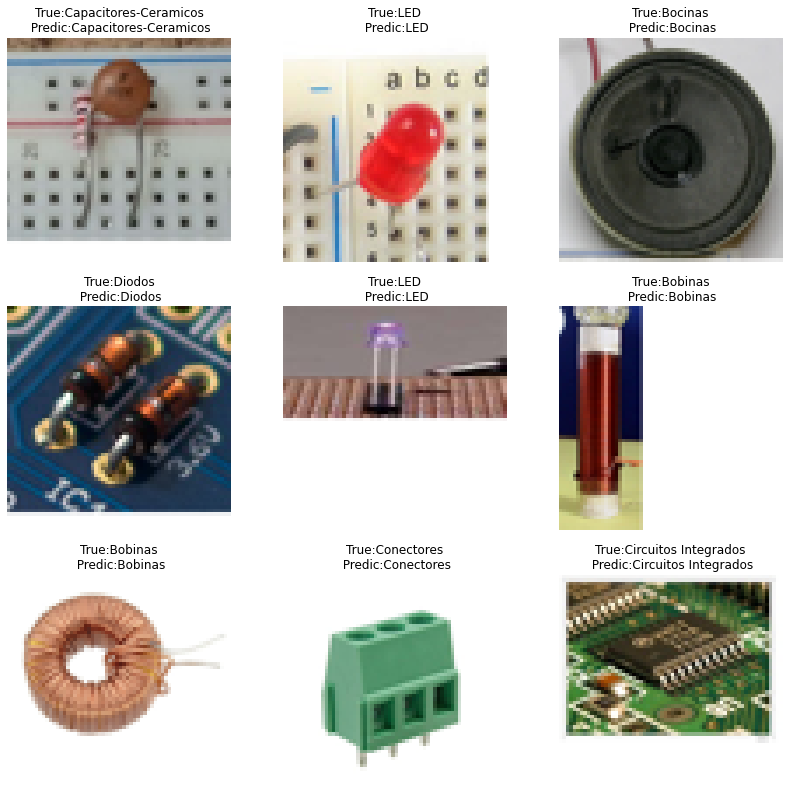

In [185]:
#Predicción sobre todo el dataset
dispositivosC = onehot_encoderC.categories_[0]

fig3 = plt.figure(figsize=(14,14))
XC=np.concatenate([x_testC,x_trainC])
YC=np.concatenate([y_test_onehotC,y_train_onehotC])

#Nueve ejemplos 
for i in range(3):
  for j in range (3):
    value = np.random.randint(0,len(XC))
    ejemplo = XC[value]
    v       = np.array( CNN_C(ejemplo) )
    d       = np.sort(v)[0] #Ordenamiento, los últimos son los más probables de pertenecer
    
    prediccion  = np.argmax(d[-1]==v)
    verdadero   = np.argmax(YC[value])

    ax   = fig3.add_subplot(3,3,i*3+(j+1))
    ax.imshow(ejemplo)
    ax.axis('off')
    label='True:'+ str(dispositivosC[verdadero]) + \
     '\n Predic:'+ str(dispositivosC[prediccion]) 
    ax.set_title(label )
    
    


#### Matriz de confusión

In [186]:
#Matriz de confusión
y_test_pred = np.argmax( CNN_C(XC), axis=1)

y_test_true  = np.argmax(YC, axis=1)

In [187]:
confusionM = confusion_matrix(y_test_true, y_test_pred)


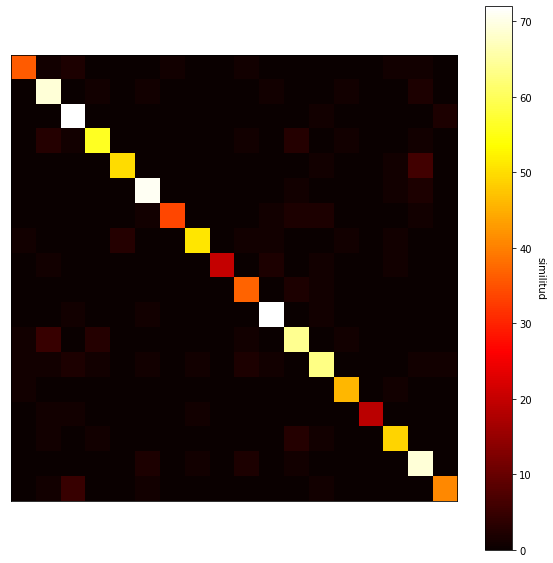

In [188]:

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(confusionM , cmap='hot')

ax.set_xticks([])
ax.set_yticks([])

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('similitud', rotation=-90, va="bottom")

plt.show()

### Segunda carga de datos

In [165]:
#implementación de la función anterior
# A elegir el tipo de carga

#direccion = dir+'DataPrep32'
direccion = dir+'DataPrep64'

x_train,x_test,y_train,y_test = CargadorDatos('Esquematicos',listaDeDispositivosEsquematicos,direccion)

In [166]:
#Forma de los datos
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((270, 64, 64, 3), (74, 64, 64, 3), (270,), (74,))

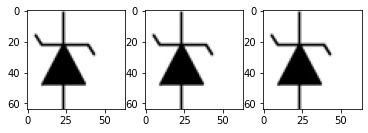

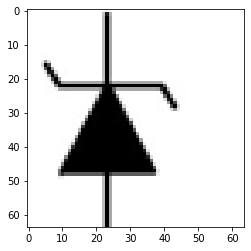

In [167]:
#Input
ex=x_train[100]

fig2 = plt.figure(figsize=(6,10))
ax   = fig2.add_subplot(1,3,1)
ax.imshow(ex[:,:,0],cmap='gray')
ax   = fig2.add_subplot(1,3,2)
ax.imshow(ex[:,:,1],cmap='gray')
ax   = fig2.add_subplot(1,3,3)
ax.imshow(ex[:,:,2],cmap='gray')

fig3 = plt.figure()
plt.imshow(ex)

In [168]:
#Aplicando one-hot y creando diccionario de traducción del mismo:

onehot_encoderE = OneHotEncoder(sparse=False)

y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoderE.fit_transform(y_train)


y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoderE.fit_transform(y_test)

#### Shuffle para evitar aprender el orden de los datos

In [169]:
x_trainE, y_trainE, y_train_onehotE = shuffle(x_train, y_train, y_train_onehot, random_state=None)
x_testE,  y_testE,  y_test_onehotE  = shuffle(x_test,  y_test,  y_test_onehot,  random_state=None)

#### Declarado de la arquitectura 2:
Esquematicos

In [170]:
class CNN_Model2(object):
  def __init__(self, clases ): 
      # Capas convolucionales

    amp=0.001 #amplitud del rand

    #3 convolucionales paralelas entre sí

    self.h1LW_A = tf.Variable(amp*np.random.randn(3,3,3,8),name="hl1_Aweigths",dtype="float32")
    self.h1LB_A = tf.Variable(amp*np.random.randn(8),name="hl1_Abias",dtype="float32")

    self.h1LW_B = tf.Variable(amp*np.random.randn(1,5,3,8),name="hl1_Bweigths",dtype="float32")
    self.h1LB_B = tf.Variable(amp*np.random.randn(8),name="hl1_Bbias",dtype="float32")

    self.h1LW_C = tf.Variable(amp*np.random.randn(5,1,3,8),name="hl1_Cweigths",dtype="float32")
    self.h1LB_C = tf.Variable(amp*np.random.randn(8),name="hl1_Cbias",dtype="float32")

  
        #MAX pooling (no tiene pesos)

        #Convolución con 16 filtros
    self.h2LW = tf.Variable(amp*np.random.randn(3,3,8*3,16),name="hl2weigths",dtype="float32")
    self.h2LB = tf.Variable(amp*np.random.randn(16),name="hl2bias",dtype="float32")
    

        #MAX pooling (no tiene pesos)

        #Flatten final
    self.h3LW = tf.Variable(amp*np.random.randn(16*16*16,512),name="hl3weigths",dtype="float32")
    self.h3LB = tf.Variable(amp*np.random.randn(512),name="hl3bias",dtype="float32")
  
    

      #Capas completamente conectadas
        #Primera reducción
    self.outW = tf.Variable(amp*np.random.rand(512, clases),name="outweigths",dtype="float32")
    self.outB = tf.Variable(amp*np.random.rand(clases),name="outbias",dtype="float32")
    
    #Para el grafo computacional, variables a entrenar:
    self.trainable_variables =[self.h1LW_A,self.h1LB_A,
                               self.h1LW_B,self.h1LB_B,
                               self.h1LW_C,self.h1LB_C,
                               self.h2LW,self.h2LB,
                               self.h3LW,self.h3LB,
                               self.outW,self.outB]

  
  def __call__(self,x,rate1=0,rate2=0):
      x   = tf.cast(x, tf.float32) #Volvemos float32 porque TF explota sino (? aver)
      img = tf.reshape(x, shape=[-1, 64, 64, 3])  #Reshape con: batch, ancho, alto, colores 
      # 64*64*3
     
      # Primer Convolucional 
      l1_A = tf.nn.conv2d(img, self.h1LW_A, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color  
    
      l1_A = tf.add(l1_A, self.h1LB_A)
      l1_A = tf.nn.relu(l1_A)
      l1_A = tf.nn.max_pool(l1_A, ksize=2, strides=2, padding='SAME' )
      l1_A = self.Normalizar(l1_A)
      # 32 * 32 * 16
      
       #Segunda convolucional paralela
      l1_B = tf.nn.conv2d(img, self.h1LW_B, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color        
      l1_B = tf.add(l1_B, self.h1LB_B)
      l1_B = tf.nn.relu(l1_B)
      l1_B = tf.nn.max_pool(l1_B, ksize=2, strides=2, padding='SAME' )
      l1_B = self.Normalizar(l1_B)
      # 32 * 32 * 16

        #Tercera convolucional paralela
      l1_C = tf.nn.conv2d(img, self.h1LW_C, strides=[1,1,1,1], padding='SAME' )  
      #Salto entre batches, [espacial, espacial], filtro/color        
      l1_C = tf.add(l1_C, self.h1LB_C)
      l1_C = tf.nn.relu(l1_C)
      l1_C = tf.nn.max_pool(l1_C, ksize=2, strides=2, padding='SAME' )
      l1_C = self.Normalizar(l1_C)
      
      # 32 * 32 * 16


      l1 = tf.concat([l1_A,l1_B,l1_C],3)
      l1 = tf.nn.dropout(l1,rate1)  


      #Concatenado de las tres paralelas 32*32*(16+16+16)
      
      
      l2 = tf.nn.conv2d(l1,self.h2LW, strides=[1,1,1,1], padding='SAME')  
      l2 = tf.add(l2, self.h2LB)
      l2 = tf.nn.relu(l2)
      l2 = tf.nn.max_pool(l2, ksize=2, strides=2, padding='SAME')
      l2 = self.Normalizar(l2)
      l2 = tf.nn.dropout(l2,rate1)  
      # 16 * 16 * 32
      
      #Capas completamente conectadas
      l3 = tf.reshape(l2,[-1, 16*16*16])
      l3 = tf.add(tf.matmul(l3,self.h3LW),self.h3LB)
      l3 = tf.nn.relu(l3)
      
      l3 = self.Normalizar(l3)

      l3 = tf.nn.dropout(l3,rate2)    
   
      
      output = tf.add( tf.matmul(l3,self.outW) , self.outB)
      #output = output/tf.reduce_max(output)


      return output 

  
  def Normalizar(self, layerIn):
      f = tf.reduce_max(abs(layerIn))
      m = tf.reduce_mean(layerIn)
      s = tf.math.reduce_std(layerIn)
      return (layerIn-m)/(s*f)         

In [171]:
CNN_Esquematicos= CNN_Model2(clases = len(listaDeDispositivosEsquematicos))

#### Entrenamiento 2

In [172]:

def fittingE(model,train_x,train_y,test_x,test_y,
            epochs,batchSize,
            rate1,rate2,
            lamb):


  #Mientras el valor de la epoca actual sea menor que la cantidad total de datos:
  for epoch in range(epochs):
    i=0
    
    #Bucle del training step
      #agregando suffle, diferentes batches cada vez
    train_x,train_y = shuffle(train_x,train_y, random_state=None)
    while i<len(train_x):
      start = i

      if (i+batchSize)<len(train_x):
        end = i+batchSize  
      else:
        end = len(train_x)
      batch_x = train_x[start:end]
      batch_y = train_y[start:end]
      
      TrainingStep( model, batch_x, batch_y, rate1,rate2,lamb)
      
      #Guardado
      #with trainE_summary_writer.as_default():
      #  tf.summary.scalar('loss', train_loss.result(), step=epoch)
      #  tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

      i+=batchSize

    TestStep( model,test_x,test_y,lamb )

    #Guardado 
    #with testE_summary_writer.as_default():
    #  tf.summary.scalar('loss', test_loss.result(), step=epoch)
    #  tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
      

    #Presentación de resultados
    template = 'Epoch {0}, Perdida: {1:.3f}, Exactitud: {2:.3f}, Perdida de prueba: {3:.3f}, Exactitud de prueba: {4:.3f}'
    if (epoch+1)%5==0:
      print(template.format(epoch+1,
                        train_loss.result().numpy(),
                        train_accuracy.result().numpy()*100,
                        test_loss.result().numpy(),
                        test_accuracy.result().numpy()*100    )   )
    
    #Early stopping
    if( train_accuracy.result().numpy()>0.90 and test_accuracy.result().numpy()>0.60 ):
      print('stop')
      break;
      
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    
    
      

## Carga de modelos pre-entrenados 
La visualización de resultados utiliza estos modelos, \
para revisar los modelos que se entrenan debe cambiarse los nombres en cuestión.

In [173]:

os.chdir(dir) #Subimos a directorio principal para cargar de aquí el modelo
CNN_E = pickle.load(open('CNN_Esquematicos_Modelo_5', 'rb'))

In [ ]:
fittingE( CNN_Esquematicos,x_trainE,y_train_onehotE, x_testE,y_test_onehotE,
        epochs= 200, batchSize = 16,
        rate1 = 0.6, rate2=0.3,
        lamb=1e-6)

#### Ejemplo de evaluación modelo 2

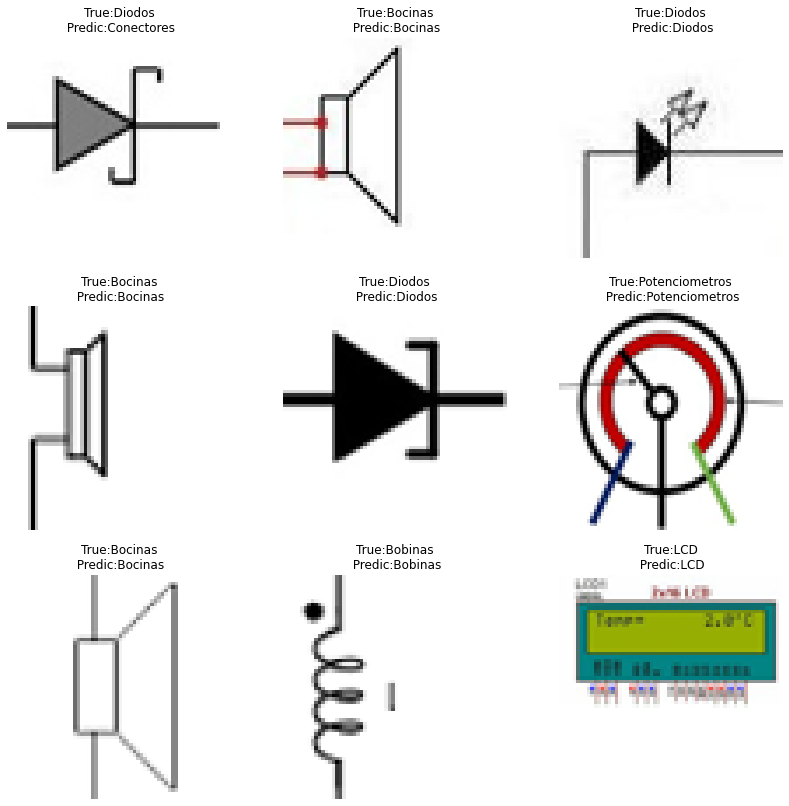

In [189]:
dispositivosE = onehot_encoderE.categories_[0]
XE=np.concatenate([x_testE,x_trainE])
YE=np.concatenate([y_test_onehotE,y_train_onehotE])
fig4 = plt.figure(figsize=(14,14))


#Nueve ejemplos 
for i in range(3):
  for j in range (3):
    value = np.random.randint(0,len(x_testE))
    ejemplo = XE[value]
    v       = np.array( CNN_E(ejemplo) )
    d       = np.sort(v)[0] #Ordenamiento, los últimos son los más probables de pertenecer
    
    prediccion  = np.argmax(d[-1]==v)
    verdadero   = np.argmax(YE[value])

    ax   = fig4.add_subplot(3,3,i*3+(j+1))
    ax.imshow(ejemplo)
    ax.axis('off')
    label='True:'+ str(dispositivosE[verdadero]) + \
     '\n Predic:'+ str(dispositivosE[prediccion]) 
    ax.set_title(label )
    
    


#### Matriz de confusión

In [190]:
#Matriz de confusión
y_test_pred = np.argmax( CNN_E(XE), axis=1)
y_test_true  = np.argmax(YE, axis=1)

In [191]:
confusionM = confusion_matrix(y_test_true, y_test_pred)


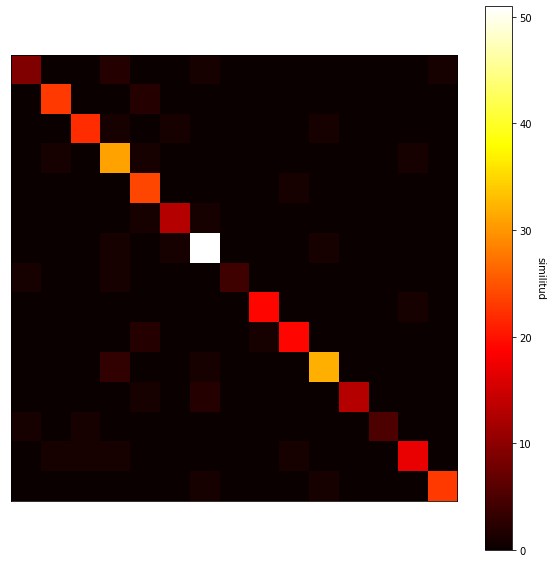

In [192]:

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(confusionM , cmap='hot')

ax.set_xticks([])
ax.set_yticks([])

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('similitud', rotation=-90, va="bottom")

plt.show()

### Guardado de los modelos y su respectiva carga

In [179]:
#Guardado de los datos, comentado
#os.chdir(dir) #Subimos a directorio principal para guardar aquí el modelo
#pickle.dump(CNN_Componentes, open('CNN_Componentes_Modelo_3', 'wb'))
#pickle.dump(CNN_Esquematicos, open('CNN_Esquematicos_Modelo_5', 'wb'))
  